In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 400)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_fc(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)



In [4]:
def loss_function(recon_x, x, mu, logvar, use_recon_loss=True, use_kl_loss=True):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') if use_recon_loss else 0
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) if use_kl_loss else 0
    return recon_loss + kl_divergence

# Train function
def train_vae(model, data_loader, epochs=10, use_recon_loss=True, use_kl_loss=True):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch, (x, _) in enumerate(data_loader):
            x = x.to(torch.float32)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            loss = loss_function(recon_x, x, mu, logvar, use_recon_loss, use_kl_loss)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {train_loss/len(data_loader.dataset):.4f}")
    return model

# Visualization function
def visualize_latent_space(model, data_loader):
    model.eval()
    all_mu = []
    labels = []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(torch.float32)
            mu, _ = model.encode(x)
            all_mu.append(mu)
            labels.append(y)
    
    all_mu = torch.cat(all_mu).numpy()
    labels = torch.cat(labels).numpy()
    plt.figure(figsize=(8,6))
    plt.scatter(all_mu[:, 0], all_mu[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar()
    plt.title("Latent Space Visualization")
    plt.show()



## Standard VAE Training

The latent space visualization shows well-separated clusters of different digit classes. The reconstruction quality is high, and the generated images follow a meaningful transformation across the latent space.

Reconstruction loss is important because without reconstruction loss, the VAE does not learn to map input data to useful latent representations. It leads to an unstructured or collapsed latent space where meaningful interpolation is not possible.  
Poor reconstruction leads to less realistic samples.  


Epoch 1, Loss: 192.2169
Epoch 2, Loss: 169.5209
Epoch 3, Loss: 164.6708
Epoch 4, Loss: 161.8373
Epoch 5, Loss: 159.8805
Epoch 6, Loss: 158.3543
Epoch 7, Loss: 157.0696
Epoch 8, Loss: 156.1108
Epoch 9, Loss: 155.2891
Epoch 10, Loss: 154.6562


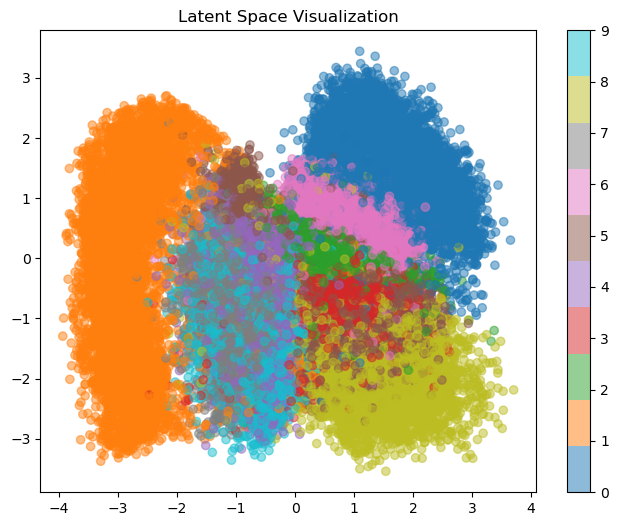

In [5]:
# Train and visualize standard VAE
vae = VAE()
vae = train_vae(vae, data_loader, epochs=10)
visualize_latent_space(vae, data_loader)


## Training without Reconstruction Loss

The loss drops to near zero because the reconstruction loss term is removed. The latent space visualization shows a highly collapsed and unstructured distribution with values close to zero. The model fails to learn meaningful representations for digits since it has no incentive to reconstruct them.
.



Epoch 1, Loss: 0.0006
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000


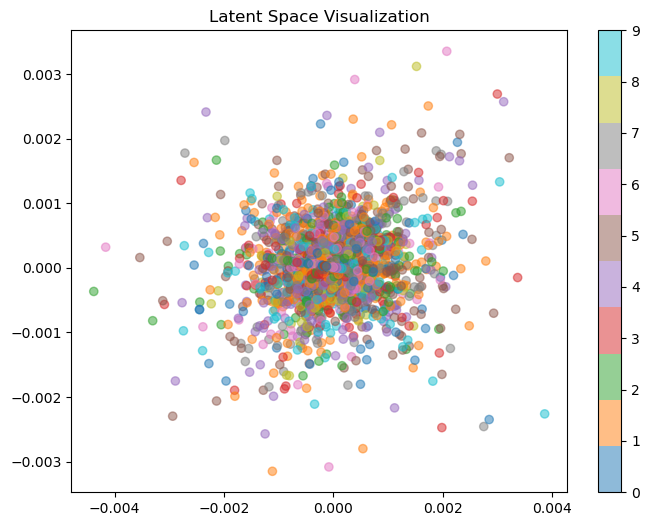

In [6]:

# Train without reconstruction loss
vae_no_recon = VAE()
vae_no_recon = train_vae(vae_no_recon, data_loader, epochs=10, use_recon_loss=False)
visualize_latent_space(vae_no_recon, data_loader)


## Training without KL Divergence Loss

The loss still decreases significantly, but the latent space shows clusters of digits that are well-separated. Without KL loss, the model does not enforce a Gaussian prior on the latent space, leading to uncontrolled distribution of encoded data. The structure is more rigid and separated, which can lead to poor generalization.


Epoch 1, Loss: 182.7605
Epoch 2, Loss: 161.2079
Epoch 3, Loss: 156.0667
Epoch 4, Loss: 153.3315
Epoch 5, Loss: 151.4575
Epoch 6, Loss: 150.0250
Epoch 7, Loss: 148.8215
Epoch 8, Loss: 147.8735
Epoch 9, Loss: 146.9964
Epoch 10, Loss: 146.2369


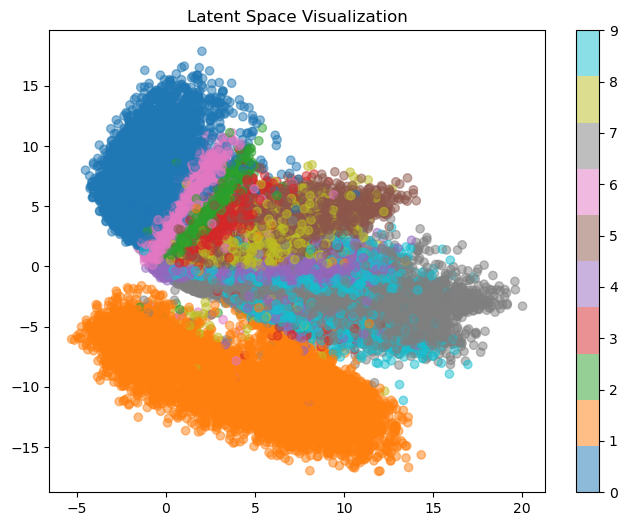

In [7]:

# Train without KL Divergence loss
vae_no_kl = VAE()
vae_no_kl = train_vae(vae_no_kl, data_loader, epochs=10, use_kl_loss=False)
visualize_latent_space(vae_no_kl, data_loader)


## Generating Images from a Gaussian Grid

The generated digits show a smooth transition from one class to another. The latent space captures the distribution of digits well, demonstrating a structured mapping from the latent space to meaningful digits.




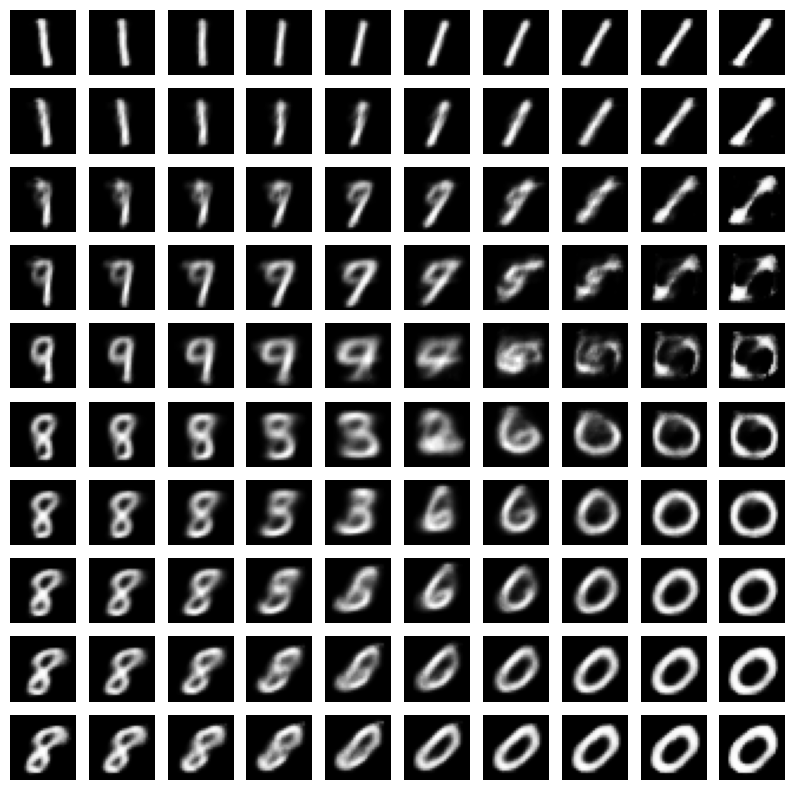

In [8]:

# Generate images from a Gaussian grid
z1 = np.linspace(-3, 3, 10)
z2 = np.linspace(-3, 3, 10)
zz = np.array([[z1_, z2_] for z1_ in z1 for z2_ in z2])
zz = torch.tensor(zz, dtype=torch.float32)
vae.eval()
generated_images = vae.decode(zz).detach().numpy().reshape(-1, 28, 28)

fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')
plt.show()


## Training with MSE Loss Instead of Binary Cross-Entropy (BCE)

The latent space distribution is still structured, similar to the standard VAE. However, the reconstructed digits appear blurrier, indicating that MSE loss does not penalize pixel-wise errors as effectively as BCE. The transition between digits in the Gaussian grid is less smooth compared to the BCE version.




Epoch 1, Loss: 190.8008
Epoch 2, Loss: 169.3542
Epoch 3, Loss: 164.8139
Epoch 4, Loss: 162.0541
Epoch 5, Loss: 160.1168
Epoch 6, Loss: 158.7154
Epoch 7, Loss: 157.4195
Epoch 8, Loss: 156.3615
Epoch 9, Loss: 155.5205
Epoch 10, Loss: 154.6876


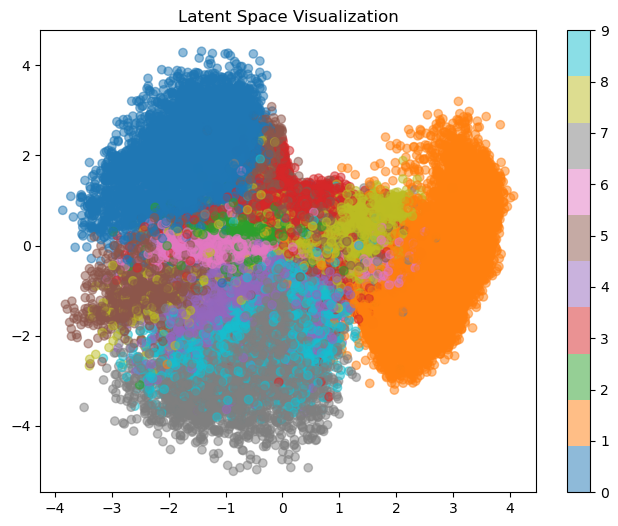

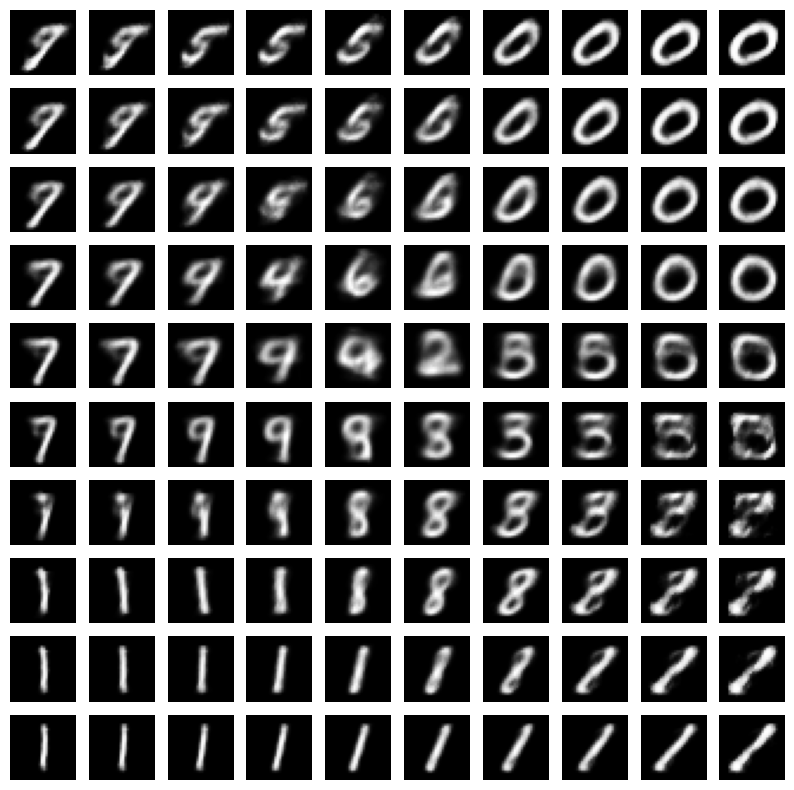

In [9]:

# Train with MSE loss instead of BCE
def loss_function_mse(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

vae_mse = VAE()
vae_mse = train_vae(vae_mse, data_loader, epochs=10)
visualize_latent_space(vae_mse, data_loader)

vae_mse.eval()
generated_images_mse = vae_mse.decode(zz).detach().numpy().reshape(-1, 28, 28)

fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images_mse[i], cmap='gray')
    ax.axis('off')
plt.show()


### finally
Reconstruction loss ensures meaningful representations, while KL loss enforces structure in the latent space for smooth interpolation.